#### Objectives:
1. produce a gene occurence figure to show the distribution of genes in the pan-genome among different genomes
2. produce a gene presence/absence table
3. produce a list of fasta files, of which each contains proteins sequences in the same ortholog group.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def process_OG_line(line):
    # line is a line in output file of orthomcl. Each line is a ortholog group
    # return og_id and genome list
    cont = line.strip().split(':')
    return cont[0].strip(),[item.split('_')[0] for item in cont[1].split()]

In [3]:
def load_genomes_in_each_cluster(clsterfile):
    # input clsterfile: is a cluter file generated by orthomcl
    # return a dictionary {OG_id:list(unique genomes)}
    # 
    og_genoms = dict()
    
    for line in open(clsterfile):
        if ':' not in line: continue
        og_id,genoms = process_OG_line(line)
        og_genoms[og_id] = list(set(genoms))
    print('Number of gene groups:',len(og_genoms))
    return og_genoms

In [4]:
def calculate_gene_occurence(og_genoms):
    # return a list which contains the gene occruency of each gene (group)
    # 
    
    # 1.get total number of genomes
    all_genomes = []
    for genoms in og_genoms.values(): all_genomes+=genoms
    
    tot_genome_num = float(len(set(all_genomes)))
    print('Number of genomes:',tot_genome_num)
    
    occrs = [len(genoms)/tot_genome_num for genoms in og_genoms.values()]
    return occrs

In [5]:
def plot_gene_occurence(og_genoms,outname):
    #  produce a histogram
    # 
    occrs = calculate_gene_occurence(og_genoms)
    plt.figure(figsize=(4,3))
    plt.hist(occrs,50)
    plt.xlabel('Frequency of occurence')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(outname)
    plt.show()

Number of gene groups: 233478
Number of genomes: 343.0


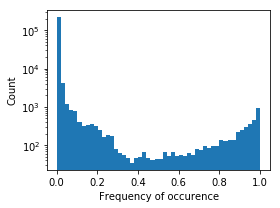

In [6]:
og_genoms = load_genomes_in_each_cluster('../data/orthomcl_output/orthomcl_clusters.txt')
plot_gene_occurence(og_genoms,'../figures/pan_genome_gene_occurence.pdf')